#1 Data importing and preprocessing

*   Improt cleaned data
*   Required libraries are imported
*   Check for GPU availability to be used by the model
*   Data split into features (X) and target (y)
*   Data split into teain_validation and test
*   Feature scaling by StandardScaler



In [14]:
!pip install optuna
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import drive
import joblib
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import TensorDataset, DataLoader
import os
import optuna


# Check GPU
print("GPU Available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU")

# Choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


#import cleaned data storred in the previous notebook (01_Data_cleaning_inspection)
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/data/interim/cleaned_data.parquet'
df = pd.read_parquet(file_path)

# Target (y) and independent variables (X)
y = df['Demand Forecast']
X = df.drop(columns = ['Demand Forecast'])

# Display five rows of X and y
print("*************************************")
print("First five rows of X and y:")
print("*************************************")
print(f"First five rows of X:\n {X.head(5)}")
print("*************************************")
print(f"\nFirst five rows of y:\n {y.head(5)}")
print("*************************************")
#split X and y into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)  # shape (n, 1)
X_test = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Feature Scaling
standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train)
X_test_scaled = standard_scaler.transform(X_test)



GPU Available: False
Running on CPU
Using device: cpu
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
*************************************
First five rows of X and y:
*************************************
First five rows of X:
    Inventory Level  Units Sold  Units Ordered  Price  Discount  \
0              231         127             55  33.50        20   
1              204         150             66  63.01        20   
2              102          65             51  27.99        10   
3              469          61            164  32.72        10   
4              166          14            135  73.64         0   

   Holiday/Promotion  Competitor Pricing  Store ID_S001  Store ID_S002  \
0                  0               29.69            1.0            0.0   
1                  0               66.16            1.0            0.0   
2                  1               31.32            1.0            0.0 

**Results of above cell show that the data imported properly**



#2. Model building - PyTorch


In [15]:
class ANNModel(nn.Module):
  def __init__(self, input_dim, num_layers, hidden_units, activation_fn):
    #parent constructor
    super().__init__()
    #Initialize Layers List
    layers = []
    #Set Initial Input Dimension
    in_features = input_dim
    #Hidden Layers Loop
    for _ in range(num_layers):
      #Add Linear Layer
      layers.append(nn.Linear(in_features, hidden_units))
      # Add Activation Function
      layers.append(activation_fn)
      # Update Input Dimension
      in_features = hidden_units
    # output layer
    layers.append(nn.Linear(hidden_units, 1))
    #Create Sequential Network
    self.network = nn.Sequential(*layers)
  #Forward Pass Method
  def forward(self, x):
    return self.network(x)

#Obj function for optuna
def objective(trial):

    # Hyperparameters to tune
    num_layers = trial.suggest_int("num_layers", 1, 3)
    hidden_units = trial.suggest_int("hidden_units", 16, 128, step=16)
    activation_name = trial.suggest_categorical("activation", ["relu", "tanh"])
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    activation_fn = nn.ReLU() if activation_name == "relu" else nn.Tanh()

    # Model, loss, optimizer
    model = ANNModel(X_train.shape[1], num_layers, hidden_units, activation_fn).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # DataLoader
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # Training loop
    epochs = 50
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # Validation (using test set)
    model.eval()
    with torch.no_grad():
        X_test_gpu = X_test.to(device)
        y_pred = model(X_test_gpu)
        mse = mean_squared_error(y_test.cpu().numpy(), y_pred.cpu().numpy())
    return mse

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)  # Try 10 different configurations

print("*************************************")
print("\n Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")
print("*************************************")

# Train final model using best params
best_params = study.best_params
activation_fn = nn.ReLU() if best_params["activation"] == "relu" else nn.Tanh()

final_model = ANNModel(
    X_train.shape[1],
    best_params["num_layers"],
    best_params["hidden_units"],
    activation_fn
).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params["learning_rate"])

train_loader = DataLoader(TensorDataset(X_train, y_train),
                          batch_size=best_params["batch_size"], shuffle=True)

epochs = 100
for epoch in range(epochs):
    final_model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = final_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

# Evaluate final model

final_model.eval()
with torch.no_grad():
    X_test_gpu = X_test.to(device)
    y_pred_gpu = final_model(X_test_gpu)
    y_pred = y_pred_gpu.cpu().numpy()

mse = mean_squared_error(y_test.cpu().numpy(), y_pred)
r2 = r2_score(y_test.cpu().numpy(), y_pred)
print("    ")
print("*************************************")
print(f"\n Final Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print("*************************************")



[I 2025-10-05 22:23:57,433] A new study created in memory with name: no-name-fea3e7fc-8c9e-46e9-9f73-c98269fc9de0
[I 2025-10-05 22:25:28,446] Trial 0 finished with value: 167.54812622070312 and parameters: {'num_layers': 1, 'hidden_units': 96, 'activation': 'tanh', 'learning_rate': 0.0018439709265418408, 'batch_size': 64}. Best is trial 0 with value: 167.54812622070312.
[I 2025-10-05 22:30:33,204] Trial 1 finished with value: 144.08355712890625 and parameters: {'num_layers': 2, 'hidden_units': 112, 'activation': 'tanh', 'learning_rate': 0.0010141772723690407, 'batch_size': 16}. Best is trial 1 with value: 144.08355712890625.
[I 2025-10-05 22:34:09,047] Trial 2 finished with value: 76.54293823242188 and parameters: {'num_layers': 1, 'hidden_units': 80, 'activation': 'relu', 'learning_rate': 0.00012793678980646986, 'batch_size': 16}. Best is trial 2 with value: 76.54293823242188.
[I 2025-10-05 22:37:14,095] Trial 3 finished with value: 92.15948486328125 and parameters: {'num_layers': 3, 

*************************************

 Best hyperparameters:
num_layers: 1
hidden_units: 32
activation: relu
learning_rate: 0.000341234845822625
batch_size: 16
*************************************
    
*************************************

 Final Evaluation:
Mean Squared Error (MSE): 75.71
R-squared (R²): 0.99
*************************************


# 3. Performance analysis of the model by below plots
*   Actual vs predicted
*   Residual error


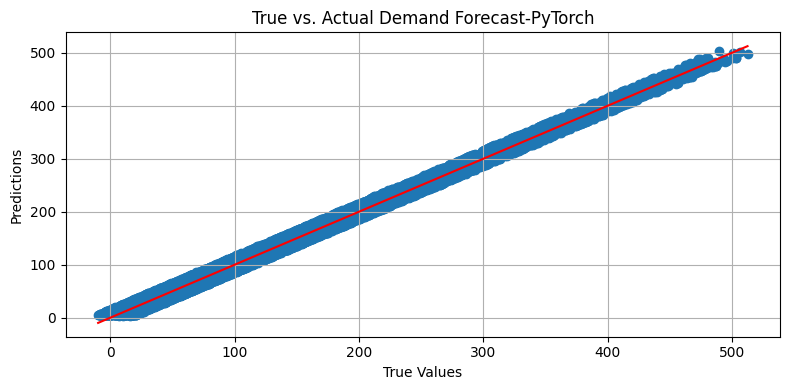

/tmp/ipython-input-2046409224.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  residuals = y_test - y_pred
/tmp/ipython-input-2046409224.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


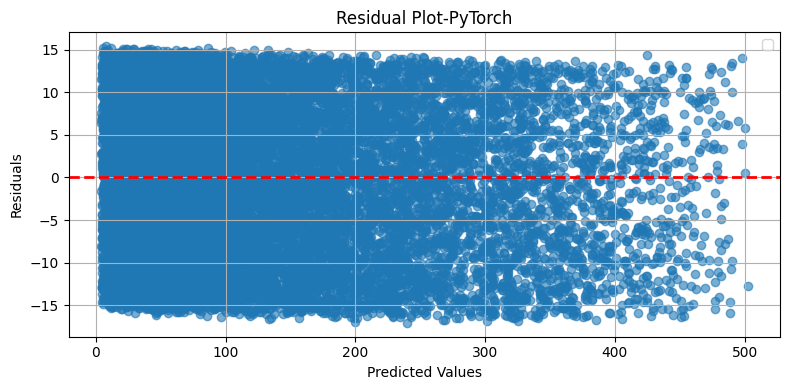

In [16]:
os.makedirs('plots', exist_ok=True)
# Plot predictions (actual/predicted) and residual
#(actual/predicted) plot
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs. Actual Demand Forecast-PyTorch")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/plots/True_Actual_Demand_Forecast_tr.png')
plt.show()
# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot-PyTorch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/plots/Residual_Plot_tr.png')
plt.show()



**According to plots and results of the model, it has been trained well.**


#6. Save the best model

In [1]:
# Save your trained model
import joblib
file_path2 = '/content/drive/MyDrive/Colab Notebooks/DL_model_pytorch.pkl'
joblib.dump(final_model, file_path2)
print("Model saved successfully!")

NameError: name 'final_model' is not defined